In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import contextily as ctx

import datetime as dt
from datetime import datetime

import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd

import rioxarray as rxr
import xarray as xr
import rasterio as rio
import matplotlib

### Load data:

In [2]:
#wstates = gpd.read_file('../data/misc/western_states.shp')
#wstates_4326=wstates.to_crs('epsg:4326')
#cluster_polys = gpd.read_file('../data/cluster_polygons.geojson')
#wus_boundary = gpd.read_file('../data/misc/western_boundary.geojson')
station_clusters = pickle.load(open('../data/combined_snotel_cdec/station_clusters.pkl', 'rb'))
#cluster_polys = gpd.read_file('../data/cluster_polygons.geojson')
#huc10_wus = gpd.read_file('../data/huc10.geojson')

In [3]:
station_anom = pickle.load(open('../data/combined_snotel_cdec/combined_april1_anom_sdev.pkl', 'rb'))
station_swe = pickle.load(open('../data/combined_snotel_cdec/combined_april1_swe.pkl', 'rb'))
station_mean_sdev = pickle.load(open('../data/combined_snotel_cdec/combined_april1_mean_stdev.pkl', 'rb'))

In [7]:
ds = xr.open_dataset('../data/reanalysis/SWE_reanalysis_32yrs.nc')

In [8]:
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 ...
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 ...

### Calculate the 32-year SWE Reanalysis mean:  
Exclude pixels with <0.1 mm SWE

In [5]:
#anomalies = ds.SWE_Post - ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

In [11]:
mean_swe = ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

### Calculate standard deviation of the SWE data:

In [12]:
ds_stdev = ds.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(ds.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [29]:
anomalies_sdev = anomalies / ds_stdev

### Interpolate Reanalysis Product at Snotel Location

To interpolate at each snotel location:  
* SWE
* Mean SWE
* SWE standard deviation

In [13]:
station_swe.columns = station_swe.columns.astype('str')

In [14]:
coord = [station_clusters.loc['380_CO_SNTL'].geometry.x, station_clusters.loc['380_CO_SNTL'].geometry.y]
coord

[-106.9530029296875, 38.89432907104492]

(38.87, 38.91)

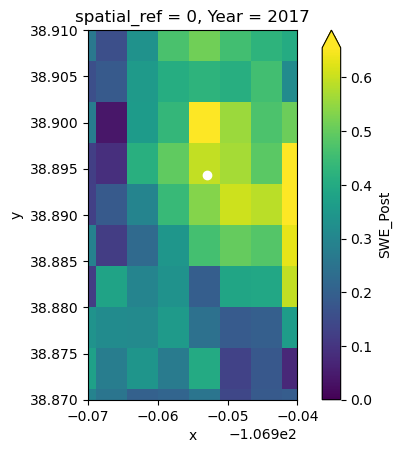

In [15]:
fig, ax = plt.subplots()

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

ds.SWE_Post[27].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax, legend=True, color='white')

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

(38.87, 38.91)

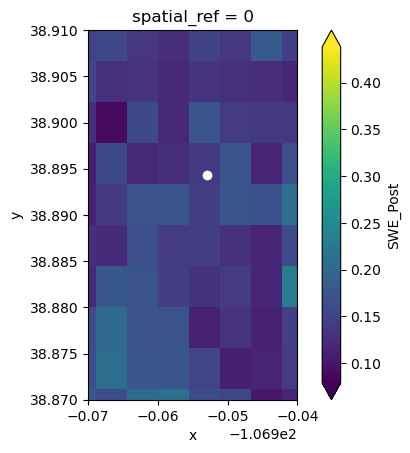

In [17]:
fig, ax = plt.subplots()

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

ds_stdev.plot(ax=ax, robust=True)
station_clusters.plot(ax=ax, legend=True, color='white')

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

### Sample using built-in nearest neighbor:

In [21]:
station_ns = []
reanalysis_ns = []

for year in range(1990, 2022):
    station_ns.append((station_swe['380_CO_SNTL'][f'{year}-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL'])

    reanalysis_swe = ds.SWE_Post[year-1990].sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_mean = mean_swe.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_stdev = ds_stdev.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_ns.append((reanalysis_swe - reanalysis_mean)/reanalysis_stdev)

In [22]:
df_ns = pd.DataFrame({'station_ns':station_ns, 'reanalysis_ns':reanalysis_ns}, index=list(range(1990, 2022)))
df_ns.head()

,station_ns,reanalysis_ns
1990,-1.503178,-0.633882
1991,-0.368494,-0.821335
1992,-0.524235,0.246713
1993,2.212355,-0.165975
1994,-0.501986,-0.780647


In [23]:
temps  = pd.read_csv('../data/max_temp_mean_butte.csv')
temps.index = temps['Year']
temps = temps.drop(columns='Year')
temps.head()

,max_temp_mean
Year,
1990,-1.9225
1991,-2.6120
1992,-1.4500
1993,-2.7850
1994,-1.7050


In [24]:
df_ns['temps'] = temps['max_temp_mean']

In [25]:
r2 = np.corrcoef(df_ns['station_ns'], df_ns['reanalysis_ns'])
r2[0,1]

0.6985623315670229

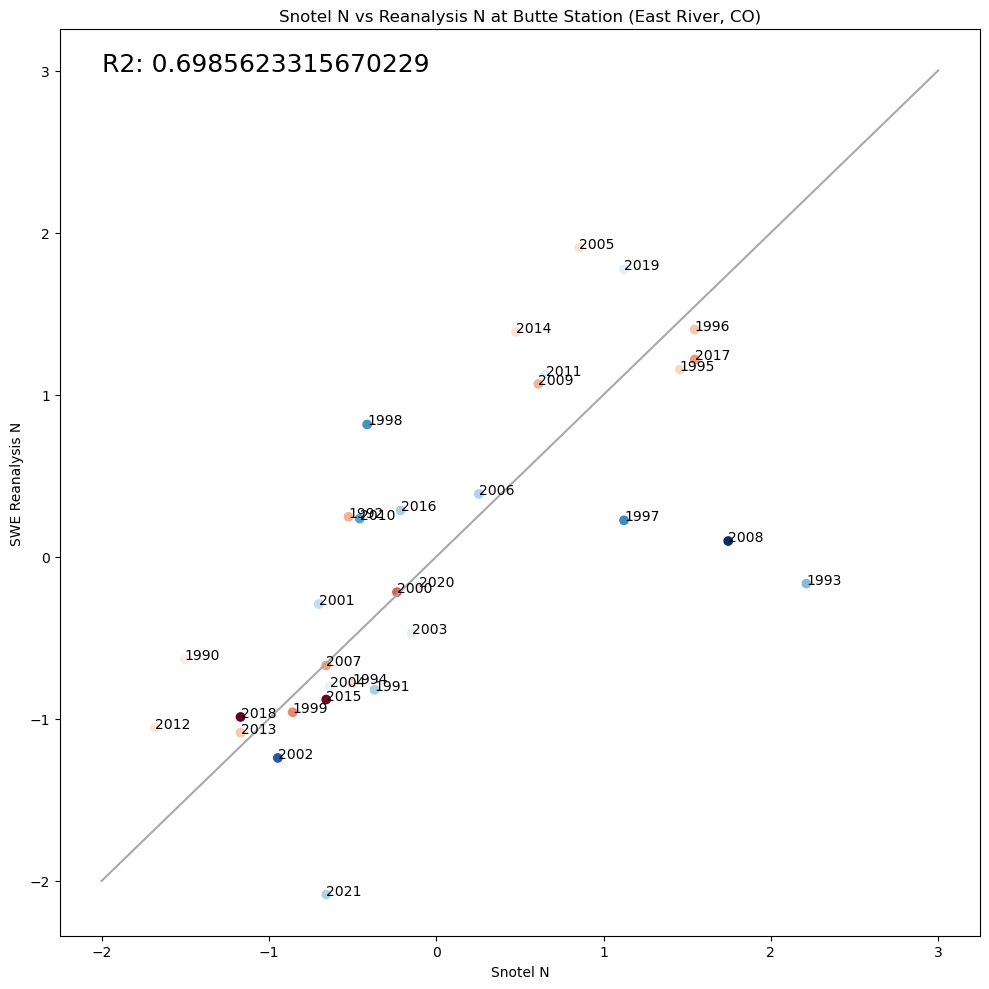

In [28]:
x = np.linspace(-2,3,100)
y = x

fig, ax = plt.subplots(figsize=(10,10)) #

plt.scatter(df_ns['station_ns'],df_ns['reanalysis_ns'], c=df_ns['temps'], cmap='RdBu_r')

for i in df_ns.index:
    ax.annotate(i, (df_ns['station_ns'][i], df_ns['reanalysis_ns'][i]))

ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_title('Snotel N vs Reanalysis N at Butte Station (East River, CO)')
ax.annotate(f"R2: {r2[0,1]}", xy=(-2,3), fontsize=18)
ax.set_xlabel('Snotel N')
ax.set_ylabel('SWE Reanalysis N')

plt.tight_layout()
#plt.savefig('../figures/n_comparison.jpeg')

## In Progress: Update Friedrich's Core Interpolate function to work with .nc files 
#### Friedrich's function allows us to sample using cubic instead of nearest neighbor. But it was written to work with .tif files, not .nc files. So far, we changed the function such that we get the same results using method='mean' when using .nc and .tif files, but not when using method='cubic'. We think it has to do with the different order of the coordinates (I think .nc defaults to y,x instead of x,y) so messing with the transform might help. Or maybe projecting both datasets into UTM with units=m?

In [39]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

# cluster_sample = core.interpolate('../../data/swe_reanalysis_5clusters.tif', coord, offset=3, kind='NN')

In [27]:
ds.rio.crs

CRS.from_epsg(4326)

In [10]:
import core
Polygon = core.Polygon
replace_and_fill_nodata_value = core.replace_and_fill_nodata_value

In [11]:
# Edited by Friedrich to help me use this interpolate function on netcdf files
# He recommended testing it against the result of the original function after converting my netcdf to tif. 
# As shown below, they result in different numbers. So this function needs some tweaking.

def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip(window_polygon_geoseries, 
                                    crs=source.rio.crs)
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)


In [12]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.39411667], dtype=float32)

In [35]:
netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc'
offset = 3
positions = [coord,]
variable_name = 'SWE_Post'
source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)

In [36]:
source = source.rio.write_crs('EPSG:4326')

In [37]:
source = source.rename({'Longitude': 'x',
               'Latitude': 'y',})

In [52]:
source = source.rio.to_crs('epsg:32612')

type: 'RasterDataset' object has no attribute 'to_crs'

In [45]:
spacing = source.rio.resolution()[0]
dx = offset * spacing
dy = offset * spacing

In [50]:
spacing

0.0044445956495216465

In [51]:
source.rio.resolution()

(0.0044445956495216465, 0.004444426152405252)

In [41]:
source

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
Data variables:
    SWE_Post     (x, y) float32 ...

In [43]:
coord

[-106.9530029296875, 38.89432907104492]

In [48]:
coord[1] + dy

38.907662857993486

In [49]:
coord[1] - dy

38.88099528409636

In [47]:
source.sel(x=slice(coord[0] - dx, coord[0] + dx), y=slice(coord[1] + dy, coord[1] - dy))

<xarray.Dataset>
Dimensions:      (y: 0, x: 6)
Coordinates:
  * y            (y) float64 
  * x            (x) float64 -107.0 -107.0 -107.0 -106.9 -106.9 -106.9
    spatial_ref  int64 0
Data variables:
    SWE_Post     (x, y) float32 ...

In [231]:
# spacing = source.rio.resolution()[0]
# dx = offset * spacing
# dy = offset * spacing

# results = []

In [232]:
# for p in positions:
#     UL = (p[0] - dx, p[1] + dy)
#     UR = (p[0] + dx, p[1] + dy)
#     LR = (p[0] + dx, p[1] - dy)
#     LL = (p[0] - dx, p[1] - dy)

# window_polygon = Polygon([UL, UR, LR, LL, UL])

In [233]:
# window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
# # window, transform = rasterio.mask.mask(
# #     source, [window_polygon], crop=True, all_touched=True
# # 
# window_ds = source.rio.clip(window_polygon_geoseries, 
#                             crs=source.rio.crs)
# window = window_ds[variable_name].data
# transform = window_ds.rio.transform

In [235]:
# transform()

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

### Convert to tif:

In [140]:
base_dir = '../data/reanalysis/swe/'
year = 2017
yr_dir = f'{base_dir}{year}/SWE_Post/'
fname = f'{base_dir}{year}/SWE_Post/{os.listdir(yr_dir)[0]}'
#fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
#ds['Year'] = 2017
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 1)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
Dimensions without coordinates: Year
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [239]:
ds.SWE_Post.rio.to_raster('../data/reanalysis_2017_swe.tif')

In [243]:
ds.rio.crs

CRS.from_epsg(4326)

In [14]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.39411667], dtype=float32)

In [17]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)

In [21]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.4224449], dtype=float32)

In [13]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='mean')

array([0.4224449], dtype=float32)

In [24]:
from scipy.interpolate import interp2d
def scipy_methods(window, coords_x, coords_y, center, kind="linear"):

    if window.shape[0] != window.shape[1]:
        return np.nan
    else:
        fun = interp2d(
            x=pd.unique(coords_x), y=pd.unique(coords_y), z=window, kind=kind
        )
        return fun(center[0], center[1])[0]

In [25]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

array([0.59223196])

In [26]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

array([0.7012757])

In [33]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        #window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = source.sel({x:slice(p[0] - dx, p[0] + dx), y:slice(p[1] + dy, p[1] - dy)})
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)

In [34]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

type: local variable 'x' referenced before assignment

In [137]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data.T
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return transform

In [138]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

In [142]:
ds.rio.transform()

Affine(0.0044445956495216465, 0.0, -125.00000214401616,
       0.0, 0.004444426152405252, 31.00007232732907)

In [106]:
window_geoseries

array([[0.379 , 0.2962, 0.332 , 0.1928, 0.3858, 0.39  , 0.5964],
       [0.1164, 0.2246, 0.3442, 0.4584, 0.4996, 0.4812, 0.6312],
       [0.182 , 0.296 , 0.4406, 0.5326, 0.6046, 0.588 , 1.0238],
       [0.089 , 0.4138, 0.4944, 0.5952, 0.5676, 0.4888, 0.6878],
       [0.0396, 0.3562, 0.4336, 0.708 , 0.556 , 0.4696, 0.5078],
       [0.1832, 0.3542, 0.4054, 0.4234, 0.41  , 0.4562, 0.3124],
       [0.1572, 0.3318, 0.4668, 0.514 , 0.4582, 0.4234, 0.4008]],
      dtype=float32)

In [113]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

array([0.7012757])

In [109]:
def interpolate(raster_file_name, positions, offset=3, kind="IDW"):

    source = rasterio.open(raster_file_name)
    spacing = source.res[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window, transform = rasterio.mask.mask(
            source, [window_polygon], crop=True, all_touched=True
        )
        window = window.squeeze()
        if source.nodata != None:
            window = replace_and_fill_nodata_value(window, source.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return results


In [110]:
import rasterio
interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

[0.7012757039688299]

In [ ]:
array([0.7012757])

In [97]:
window_geoseries

array([0.71259841])

In [86]:
window

array([[0.379 , 0.2962, 0.332 , 0.1928, 0.3858, 0.39  , 0.5964],
       [0.1164, 0.2246, 0.3442, 0.4584, 0.4996, 0.4812, 0.6312],
       [0.182 , 0.296 , 0.4406, 0.5326, 0.6046, 0.588 , 1.0238],
       [0.089 , 0.4138, 0.4944, 0.5952, 0.5676, 0.4888, 0.6878],
       [0.0396, 0.3562, 0.4336, 0.708 , 0.556 , 0.4696, 0.5078],
       [0.1832, 0.3542, 0.4054, 0.4234, 0.41  , 0.4562, 0.3124],
       [0.1572, 0.3318, 0.4668, 0.514 , 0.4582, 0.4234, 0.4008]],
      dtype=float32)

In [107]:
diff = window - window_geoseries

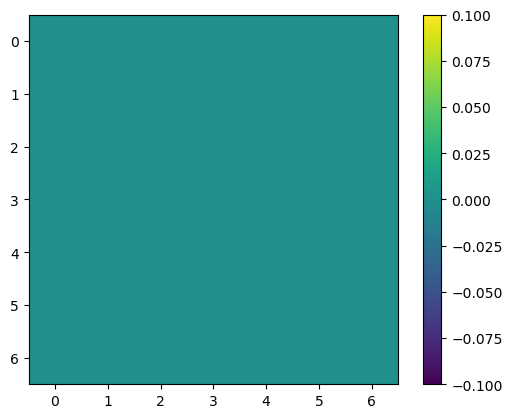

In [108]:
plt.imshow(diff)
plt.colorbar(plt.imshow(diff))

In [116]:
set(diff.flatten())

{0.0}

In [129]:
netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc'
offset = 3
positions = [coord,]
variable_name = 'SWE_Post'
source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)

In [130]:
source = source.rio.write_crs('EPSG:4326')

In [131]:
source = source.rename({'Longitude': 'x',
               'Latitude': 'y',})

In [132]:
source = source.rio.to_crs('epsg:32612')

type: 'RasterDataset' object has no attribute 'to_crs'

In [133]:
spacing = source.rio.resolution()[0]
dx = offset * spacing
dy = offset * spacing

In [134]:

window_ds = source.rio.clip_box(minx=coord[0] - dx, miny=coord[1] - dy, maxx=coord[0] + dx, maxy=coord[1] + dy)
window = window_ds[variable_name].data
transform = window_ds[variable_name].rio.transform()

In [125]:
source = rasterio.open('../data/reanalysis_2017_swe.tif')
spacing = source.res[0]
dx = offset * spacing
dy = offset * spacing

UL = (coord[0] - dx, coord[1] + dy)
UR = (coord[0] + dx, coord[1] + dy)
LR = (coord[0] + dx, coord[1] - dy)
LL = (coord[0] - dx, coord[1] - dy)

window_polygon = Polygon([UL, UR, LR, LL, UL])
window, transform = rasterio.mask.mask(
    source, [window_polygon], crop=True, all_touched=True
)

In [135]:
transform

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

In [126]:
transform

Affine(0.0044445956495216465, 0.0, -106.96827759390685,
       0.0, 0.004444426152405252, 38.88003989554358)

In [ ]:
Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

### Try again, with reprojected data:

In [152]:
ds_r = rxr.open_rasterio('../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', crs='epsg:4326')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [153]:
ds_r = ds_r.rio.set_crs('epsg:4326')

In [154]:
ds_r.rio.crs

CRS.from_epsg(4326)

In [156]:
ds_r_trans = ds_r.rio.reproject('epsg:32613')

In [157]:
ds_r_trans.to_netcdf("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc")

In [170]:
ds = xr.open_dataset("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc")

In [172]:
ds.SWE_Post.rio.nodata

nan

In [173]:
ds.rio.crs

In [159]:
ds_r_trans.rio.to_raster("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.tif")

In [175]:

def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    # source = source.rename({'Longitude': 'x',
    #                         'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:32613')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data.T
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return window

In [176]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name="../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc", 
            variable_name='SWE_Post')

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

In [177]:
# To use Dask operators, load data using dask, ie: open_dataset(chunks='auto')
# ds['variable_name'].data

type: 'variable_name'